<a href="https://colab.research.google.com/github/KeanuInterone/AutonomousDrivingGamePlayer/blob/main/AutonomousGamePlayerDataProcessor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#⚙️ Welcome to the Game Recording Data Processor ⚙️

This notebook is purpose built to process the recordings generated from the **Autonomous Game Player Framework** to create ready to use training data for the training process. 🏋️

In breif, the Autonomous Game Player Framework is a set of python files that allows you to create recordings of yourself playing a game on your computer, then using those recordings to train a model to predict actions to take given some screen input, then after a model has been trained, execute that model in the framework to watch your trained model autonomously play the game. 🤖

This notebook is solely for the purpose of preproccessing the data so that we can train with it in a separate notebook. Although this notebook was designed to create the training data for the driving game I decided to use, it should provided you with sufficient code examples to get going with your data.

Let's get into it!!

### Imports

In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import os
import time
import gc
from multiprocessing import Pool

### Configure

In [2]:
recordings_dir = '/content/drive/MyDrive/Projects/Computer Recorder/RallyRacerDirtRecordings'
examples_dir = '/content/drive/MyDrive/Projects/Computer Recorder/Segmented20ModelData'
batched_examples_dir = '/content/drive/MyDrive/Projects/Computer Recorder/Data'
window_size = 20
step_size = 1
np.random.seed(69)

# The Recordings

To start, we'll have a look at a single recording outputed from the framework. A recording is simply a pickle file containing a dictionary with the keys `screen_frames` and `key_frames`. `screen_frames` is the array containing the sequence of images recorded as you played the game. The `key_frames` is the array of recorded key states at each timestep of the recording. A `1` denotes that a key was pressed and a `0` denotes that the key was not pressed at the given time step.

### Get the list of pickle files in a directory

In [3]:
def get_pickle_file_paths(dir):
  """
  Gets the list of pickle files in a directory
  ARGS:
    dir (string): Directory
  RETURNS:
    file_names (list): List of file names
  """
  file_names = []
  for filename in os.listdir(dir):
    if filename.endswith('.pickle'):
      path = os.path.join(dir, filename)
      file_names.append(path)
  return file_names

In [4]:
# Get the recording file paths from the recordings dir
recording_file_paths = get_pickle_file_paths(recordings_dir)

In [5]:
# Print the first 5
print(recording_file_paths[:5])

['/content/drive/MyDrive/Projects/Computer Recorder/RallyRacerDirtRecordings/recording_1710207286.pickle', '/content/drive/MyDrive/Projects/Computer Recorder/RallyRacerDirtRecordings/recording_1710207490.pickle', '/content/drive/MyDrive/Projects/Computer Recorder/RallyRacerDirtRecordings/recording_1710207580.pickle', '/content/drive/MyDrive/Projects/Computer Recorder/RallyRacerDirtRecordings/recording_1710207828.pickle', '/content/drive/MyDrive/Projects/Computer Recorder/RallyRacerDirtRecordings/recording_1710207912.pickle']


### Load a pickle object

In [6]:
def load_pickle_object(file_path):
  """
  Loads and returns the object from a pickle file
  ARGS:
    file_path (string): File path
  RETURNS:
    object (dict): the pickled object
  """
  # Open file
  with open(file_path, 'rb') as handle:
    # Load data
    pickle_object = pickle.load(handle)
    return pickle_object

In [7]:
# As an example, load the first recording object
recording = load_pickle_object(recording_file_paths[0])

# Print the objects keys
print(recording.keys())

dict_keys(['key_frames', 'screen_frames'])


In [8]:
# Print the skapes of screen_frames and key_frames
print(f"Screen Frames Shape: {recording['screen_frames'].shape}")
print(f"Key Frames Shape: {recording['key_frames'].shape}")

Screen Frames Shape: (499, 256, 256, 3)
Key Frames Shape: (499, 4)


In my particular case the shapes of my first recording were as follows...

```
Screen Frames Shape: (499, 256, 256, 3)
Key Frames Shape: (499, 4)
```
`499` being the number of frames recorded

`256, 256, 3` being the RGB images

`4` being the number of keys that were set to be recorded. And in this case the 4 keys being the arrow keys, ⬆️⬅️➡️⬇️ in that order




# Let's have a look at the recording

### Display Images Function

In [9]:
def display_images(
    images,
    labels=None,
    label_title='Label',
    prediction_labels=None,
    prediction_label_title='Prediction',
    n=10,
    random=False
    ):
  """
  Displays a list of images
  ARGS:
    images (list): List of images
    labels (list, optional): List of labels
    prediction_labels (list, optional): List of prediction labels
    n (int, optional): Number of images to display
    random (bool, optional): Whether to randomize
  """
  # If random
  if random:
    random_indices = np.random.choice(len(images), n)
    images = images[random_indices]
    if labels is not None:
      labels = labels[random_indices]
    if prediction_labels is not None:
      prediction_labels = prediction_labels[random_indices]

  # n images and labels
  images = images[:n]
  if labels is not None:
    labels = labels[:n]
  if prediction_labels is not None:
    prediction_labels = prediction_labels[:n]

  # Normalize
  if images.max() > 1.0:
    images = images / 255.0

  # Rows and columns
  columns = 5
  rows = len(images) // columns + 1 if len(images) % columns != 0 else len(images) // columns

  # Plot width and height
  width = 15
  height = 4 * rows

  # Create figure and axes
  fig, axes = plt.subplots(rows, columns, figsize=(width, height))

  # Loop over plots
  for i, ax in enumerate(axes.flat):
    # Hide axis
    ax.set_xticks([])
    ax.set_yticks([])
    # Skip if no image
    if i >= len(images):
      continue
    # Set title
    title = ''
    if labels is not None:
      title += f'{label_title}: {labels[i]}\n'
    if prediction_labels is not None:
      title += f'{prediction_label_title}: {prediction_labels[i]}'
    ax.set_title(title)
    # Show image
    ax.imshow(images[i])


  plt.show()

### Show recording

In [10]:
def show_recording(recording, start_frame=0, n=20):
  """
  Displays a recording
  ARGS:
    recording (dict): Recording
    start_frame (int, optional): Start frame
    n (int, optional): Number of frames to display
  """
  key_frames = [str(key_frame) for key_frame in recording['key_frames'][start_frame:start_frame+n]]
  screen_frames = recording['screen_frames'][start_frame:start_frame+n]
  display_images(screen_frames, labels=key_frames, label_title='Key Frame', n=n)

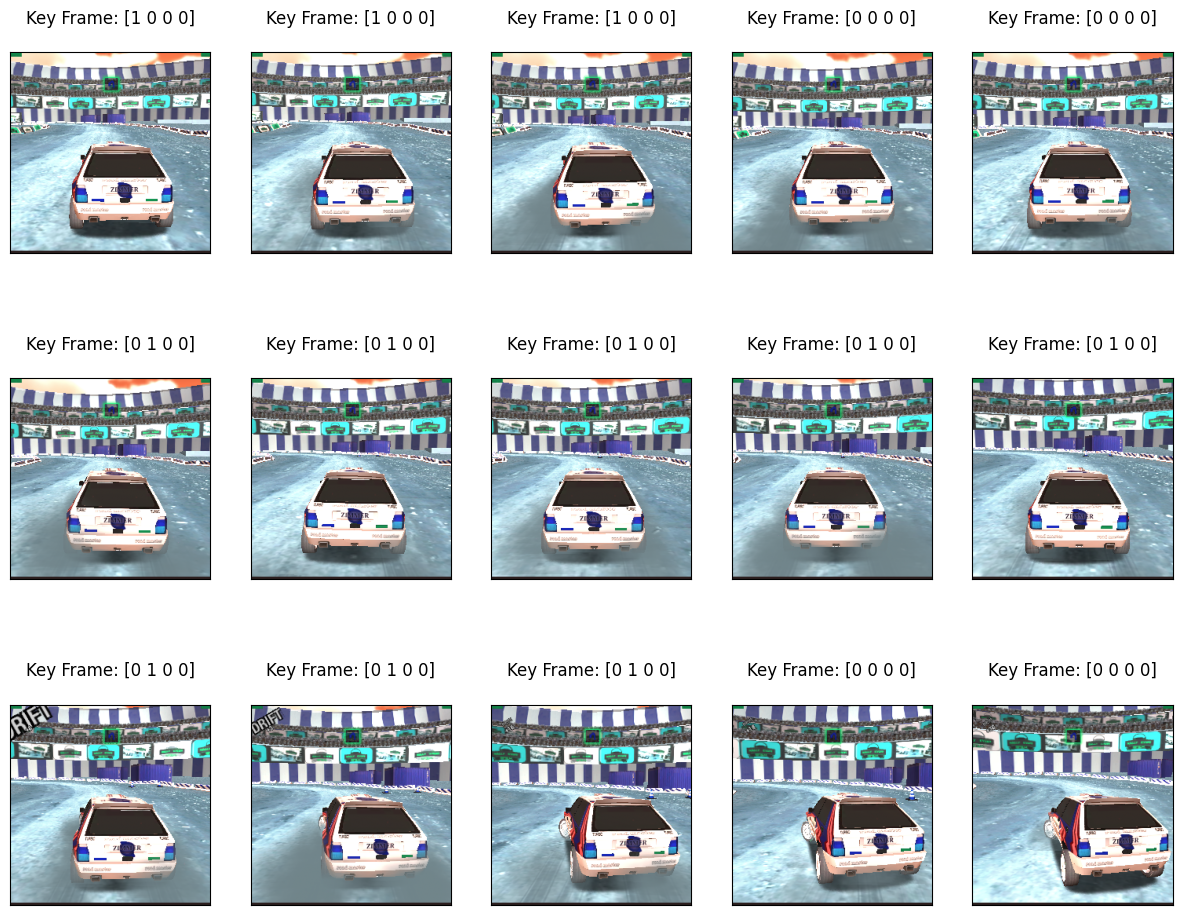

In [11]:
show_recording(recording, start_frame=90, n=15)